## Build the Network

In [29]:
!pip install wikipedia

In [30]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt

In [31]:
nx.__version__

'3.3'

In [42]:
#https://en.wikipedia.org/wiki/Retrocomputing
SEED = "Retrocomputing".title()
STOPS = ("International Standard Serial Number",
         "International Standard Book Number",
         "National Diet Library",
         "International Standard Name Identifier",
         "International Standard Book Number (Identifier)",
         "Pubmed Identifier",
         "Pubmed Central",
         "Digital Object Identifier",
         "Arxiv",
         "Proc Natl Acad Sci Usa",
         "Bibcode",
         "Library Of Congress Control Number",
         "Jstor",
         "Doi (Identifier)",
         "Isbn (Identifier)",
         "Pmid (Identifier)",
         "Arxiv (Identifier)",
         "Bibcode (Identifier)")

In [43]:
todo_lst = [(0, SEED)] # The SEED is in the layer 0 - A SEED está na camada 0
todo_set = set(SEED) # The SEED itself - A SEED em si
done_set = set() # Nothing is done yet - Nada foi feito ainda

In [44]:
g = nx.DiGraph()
layer, page = todo_lst[0]

In [45]:
%%time
while layer < 2:
  # Remove the name page of the current page from the todo_lst,
  # and add it to the set of processed pages.
  # If the script encounters this page again, it will skip over it.
  del todo_lst[0]
  done_set.add(page)

  # Show progress
  print(layer, page)

  # Attempt to download the selected page.
  try:
    wiki = wikipedia.page(page)
  except:
    print("Could not load", page)
    layer, page = todo_lst[0]
    continue

  for link in wiki.links:
    link = link.title()
    if link not in STOPS and not link.startswith("List Of"):
      if link not in todo_set and link not in done_set:
        todo_lst.append((layer + 1, link))
        todo_set.add(link)
      g.add_edge(page, link)
  layer, page = todo_lst[0]

0 Retrocomputing
1 8-Bit
Could not load 8-Bit
1 Apple I
Could not load Apple I
1 Arduino
1 Athens
1 Basic
Could not load Basic
1 Babbage
1 Black Mirror
1 Black Mirror: Bandersnatch
1 Commodore 64
Could not load Commodore 64
1 Commodore 65
1 Computer Conservation Society
1 Computer History Museum
1 Conan O'Brien
1 Copyright
1 Difference Engine
Could not load Difference Engine
1 Digital Preservation
1 Do-It-Yourself
1 Electronic Hardware
1 Emulator
1 Experimental Archaeology
1 Field-Programmable Gate Array
1 Gr8Bit
Could not load Gr8Bit
1 George R. R. Martin
1 Hdl (Identifier)
1 Hercules (Emulator)
1 History Of Computer Hardware
1 History Of Computing Hardware
1 Hobby
Could not load Hobby
1 Homebrew (Video Games)
1 Homebuilt Computer
1 Honeywell
Could not load Honeywell
1 Ibm Z
Could not load Ibm Z
1 Imsai
1 Imsai 8080
1 Living Computers: Museum + Labs
1 Ms-Dos
Could not load Ms-Dos
1 Mainframe Computer
1 Multics
1 N8Vem
1 Netflix
1 Open Source
1 Peripheral
1 Plankalkül
1 Primary School


In [46]:
print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

14241 nodes, 17726 edges


## Eliminate Duplicates

In [47]:
# make a copy of raw graph
original = g.copy()

In [48]:
# remove self loops
g.remove_edges_from(nx.selfloop_edges(g))

# identify duplicates like that: 'network' and 'networks'
duplicates = [(node, node + "s")
              for node in g if node + "s" in g
             ]

for dup in duplicates:
  # *dup is a technique named 'unpacking'
  g = nx.contracted_nodes(g, *dup, self_loops=False)

print(duplicates)

duplicates = [(x, y) for x, y in
              [(node, node.replace("-", " ")) for node in g]
                if x != y and y in g]
print(duplicates)

for dup in duplicates:
  g = nx.contracted_nodes(g, *dup, self_loops=False)

# nx.contracted creates a new node/edge attribute called contraction
# the value of the attribute is a dictionary, but GraphML
# does not support dictionary attributes
nx.set_node_attributes(g, 0,"contraction")
nx.set_edge_attributes(g, 0,"contraction")

[('Emulator', 'Emulators'), ('Peripheral', 'Peripherals'), ('Programming Language', 'Programming Languages'), ('Avr Microcontroller', 'Avr Microcontrollers'), ('Ambient Device', 'Ambient Devices'), ('Breadboard', 'Breadboards'), ('Creative Commons License', 'Creative Commons Licenses'), ('Microcontroller', 'Microcontrollers'), ('Operating System', 'Operating Systems'), ('Pic Microcontroller', 'Pic Microcontrollers'), ('Primetime Emmy Award', 'Primetime Emmy Awards'), ('Qr Code', 'Qr Codes'), ('Video Game', 'Video Games'), ('Assembly Language', 'Assembly Languages'), ('Emmy Award', 'Emmy Awards'), ('Bsd License', 'Bsd Licenses'), ('Copyright Term', 'Copyright Terms'), ('Creative Work', 'Creative Works'), ('Fair Dealing', 'Fair Dealings'), ('Open-Source License', 'Open-Source Licenses'), ('Fanzine', 'Fanzines'), ('Social Network', 'Social Networks'), ('Zine', 'Zines'), ('High-Level Programming Language', 'High-Level Programming Languages'), ('Logic Gate', 'Logic Gates'), ('Programmable L

In [49]:
print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

14178 nodes, 17674 edges


## Truncate the network

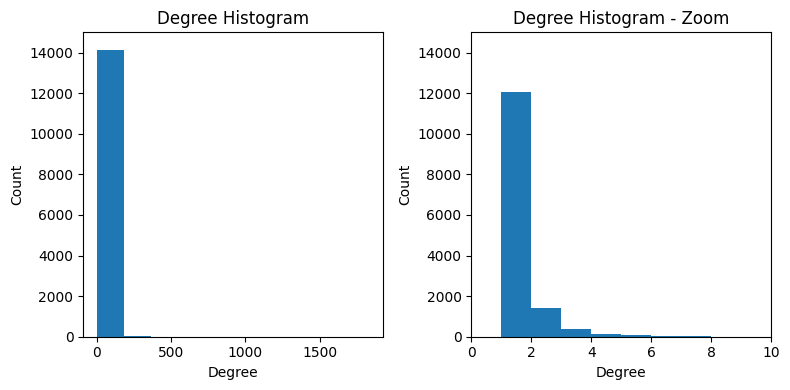

In [50]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)

fig, ax = plt.subplots(1,2,figsize=(8,4))

# all_data has information about degree_sequence and the width of each bin
ax[0].hist(degree_sequence)
ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")
ax[0].set_ylim(0,15000)

ax[1].set_title("Degree Histogram - Zoom")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Degree")
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,15000)

plt.tight_layout()
plt.show()

In [51]:
# filter nodes with degree greater than or equal to 2
core = [node for node, deg in dict(g.degree()).items() if deg >= 2]

# select a subgraph with 'core' nodes
gsub = nx.subgraph(g, core)

print("{} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))

nx.write_graphml(gsub, "seed02.graphml")

2127 nodes, 5623 edges


In [52]:
print("Nodes removed: {:.2f}%".format(100*(1 - 2127/14178)))
print("Edges removed: {:.2f}%".format(100*(1 - 5623/17674)))
print("Edges per nodes: {:.2f}".format(14178/2127))

Nodes removed: 85.00%
Edges removed: 68.18%
Edges per nodes: 6.67


## Explore the network

In [53]:
top_indegree = sorted(dict(gsub.in_degree()).items(),
                      reverse=True, key=itemgetter(1))[:100]
print("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))

24 Issn (Identifier)
21 S2Cid (Identifier)
19 Operating System
17 Wayback Machine
12 Video Game
12 Software
12 Open-Source Software
12 Linux
12 Oclc (Identifier)
11 Assembly Language
11 Embedded System
11 Personal Computer
10 Central Processing Unit
10 Printed Circuit Board
10 Youtube
10 Emulator
10 Video Game Console
9 Programming Language
9 Computer Memory
9 Internet
9 Retrocomputing
9 Integrated Circuit
9 Microprocessor
8 Computer Science
8 Hdl (Identifier)
8 Read-Only Memory
8 Github
8 Computer
8 System On A Chip
8 Ibm
8 C (Programming Language)
8 Computer Hardware
8 Germany
7 Computer History Museum
7 Algorithm
7 Apple I
7 Compiler
7 Altair 8800
7 Microsoft
7 Ms-Dos
7 Open Source
7 Flash Memory
7 Free Software
7 Commodore Pet
7 Software Release Life Cycle
7 Eeprom
7 Jstor (Identifier)
7 Microcontroller
7 Digital Rights Management
7 The New York Times
7 Digital Library
6 8-Bit Computing
6 Trs-80
6 Ascii
6 Fortran
6 Wired (Magazine)
6 Programmer
6 Mainframe Computer
6 The Wall Stree